In [1]:
%matplotlib notebook

import h5py
import matplotlib.pyplot as plt
from numpy import *
import pandas as pd
import os
import sys
import scipy.optimize as opt
from typing import Dict, Any
import recordclass.recordclass as rc
from itertools import product

# local imports
import DataH5
import HamamatsuH5

In [2]:
h5file = h5py.File('results2D.hdf5',mode='r+')

#Find number of measurements per experiment
measurements = h5file['settings/experiment/measurementsPerIteration'][()] + 1
num_its = len(h5file['iterations'])

#Find independent variable names and values
indep_vars = DataH5.get_indep_vars(h5file)
iVars = list(indep_vars.keys())

# map iterations to independent variable values
iterations = DataH5.make_iterations_df(h5file, iVars)

# Hamamatsu

In [3]:
# Set ROI
fg = HamamatsuH5.set_frame_grabber_region(h5file)
width = fg['right']-fg['left']
height = fg['bottom']-fg['top']

# For documentation try > help(HMROI)
roi = HamamatsuH5.HMROI(width,height,dic = {
    "left" : 2,
    "right" : 5,
    "top" : 4,
    "bottom" : 7
})

#Load data into memory
shots_per_measurement = int(h5file['/settings/experiment/LabView/camera/shotsPerMeasurement/function'][()])
# pixel-by-pixel data indexed : [iteration, measurement, shot, y-pixel, x-pixel]
hm_pix = HamamatsuH5.load_data(h5file,roi)

#take pixel-by-pixel data and treat it into counter data then mean data
# "count" data indexed : [iteration, measurement, shot]
hm_counts = hm_pix.sum(3).sum(3)
# mean count data indexed : [iteration, shot]
mus = hm_counts.mean(1)
# standard deviation in mean indexed : [iteration, shot]
ers = hm_counts.std(1)/sqrt(measurements)

## Plot Histograms of count data

You're about to plot 36 histograms. Are you sure you want to do that? (y/N) : y


<IPython.core.display.Javascript object>


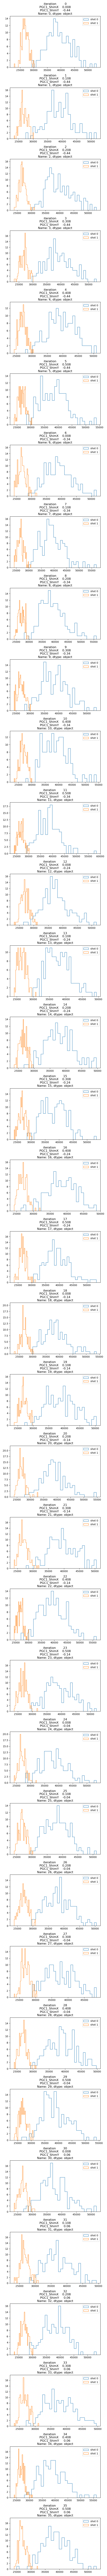

In [11]:
plots = True
if plots and len(iterations) > 22:
    ans = input(f"You're about to plot {len(iterations)} histograms. Are you sure you want to do that? (y/N) : ").upper()[0]
    plots = ans=="Y"
if plots:
    fig,axarr = plt.subplots(len(iterations),1,figsize=(6,4*len(iterations)))
    for iteration, row in iterations.iterrows():
        iteration = int(iteration)
        for shot in range(shots_per_measurement):
            axarr[iteration].hist(hm_counts[iteration,:,shot],histtype='step', label = f"shot {shot}",bins=30)
        axarr[iteration].legend()
        axarr[iteration].set_title(str(row))
        fig.tight_layout()
    fig.show()
else:
    print("You have chosen not to plot the histograms.")

## Plot mean count data
* If only 1 iteration : Prints out means for each shot and the corresponding standard deviation
* If there is 1 independent variable : Plot means for each iteration with error bars
* If there are 2 independent variables : show image of means for each iteration.

<IPython.core.display.Javascript object>


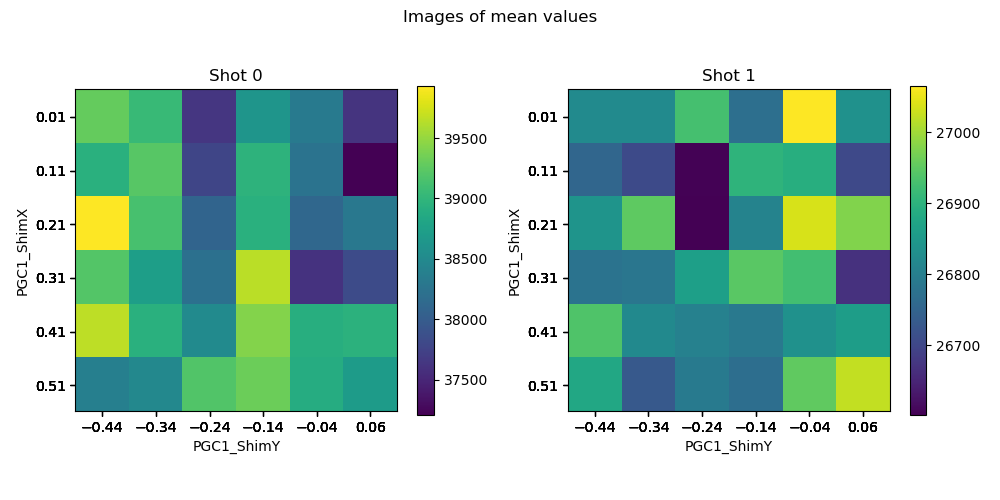

In [4]:
import PlottingH5
PlottingH5.default_plotting(iterations,mus,ers,shots_per_measurement)

## Show images taken within ROI

<IPython.core.display.Javascript object>


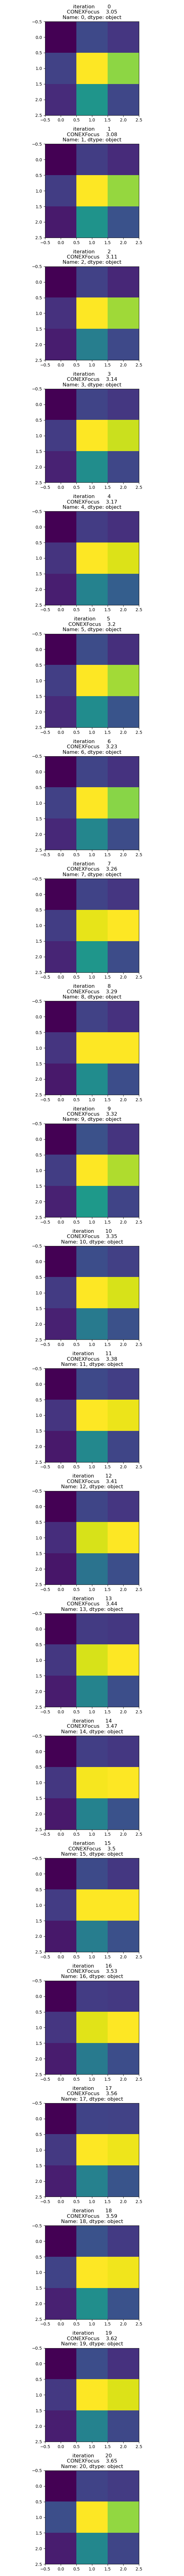

In [8]:
## show average image for one shot for each iteration
im_shot = 0 # shot to image

fig,axarr = plt.subplots(len(iterations),1,figsize=(6,4*len(iterations)))
for iteration, row in iterations.iterrows():
    i = row['iteration']
    ivs = {iVar: row[iVar] for iVar in iVars}
    axarr[i].imshow(hm_pix[i,:,im_shot,:,:].mean(0))
    axarr[i].set_title(str(row))
fig.tight_layout()
fig.show()

## Plot Histgram data of each picture for each iteration
* Very memory hungry!
* Please clear output before saving, copying or pushing if this cell was run

<IPython.core.display.Javascript object>


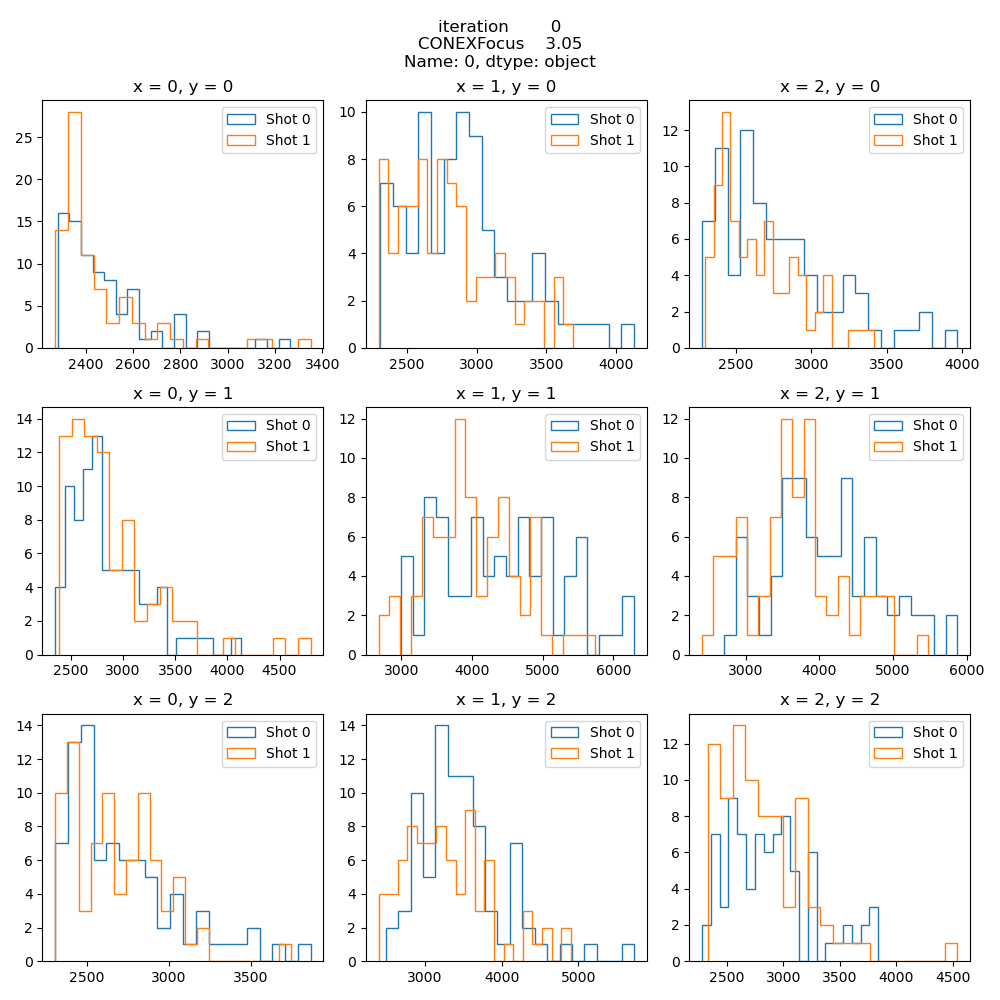

<IPython.core.display.Javascript object>


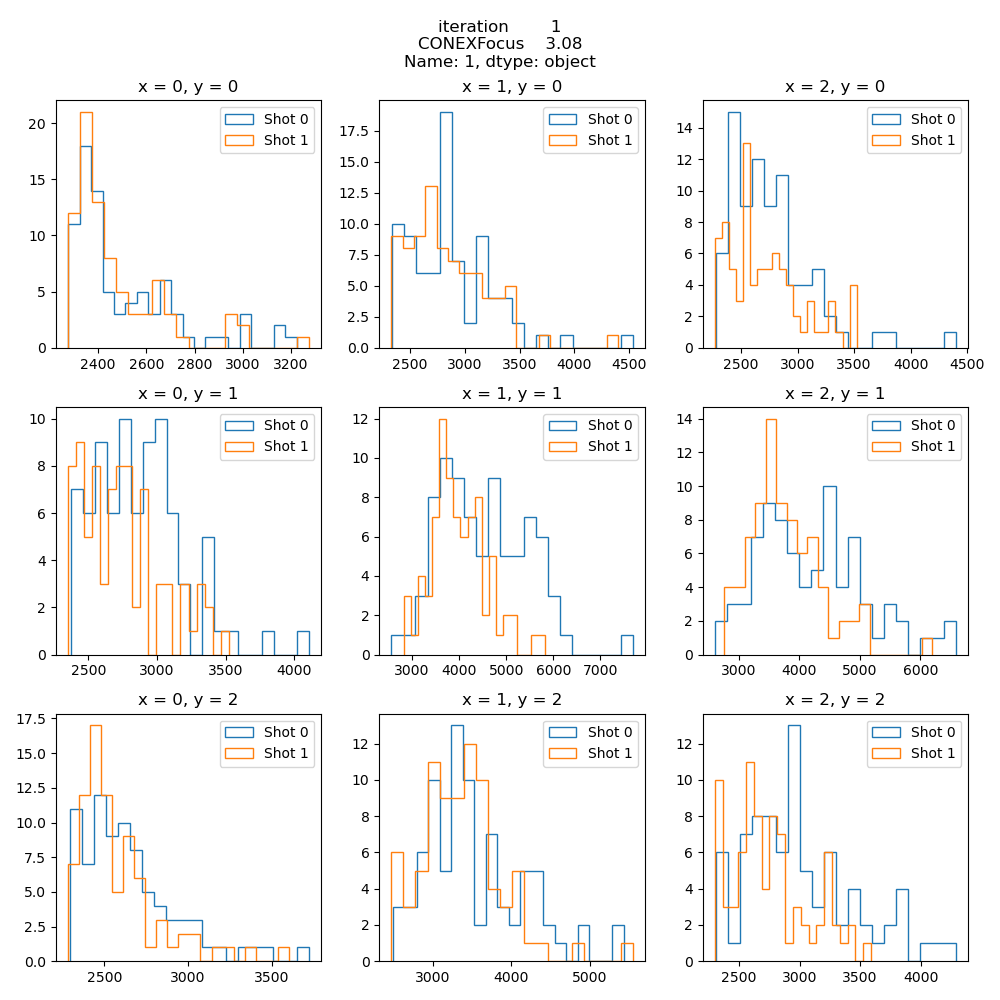

<IPython.core.display.Javascript object>


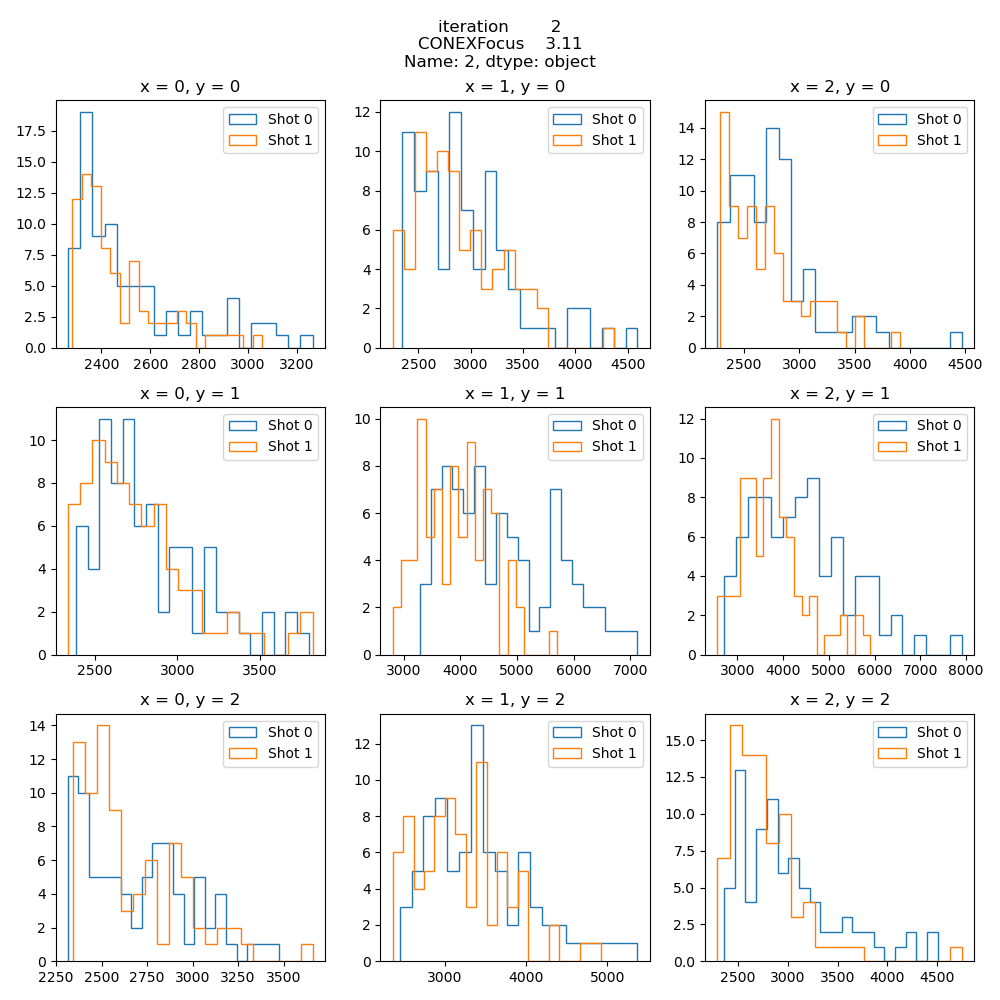

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


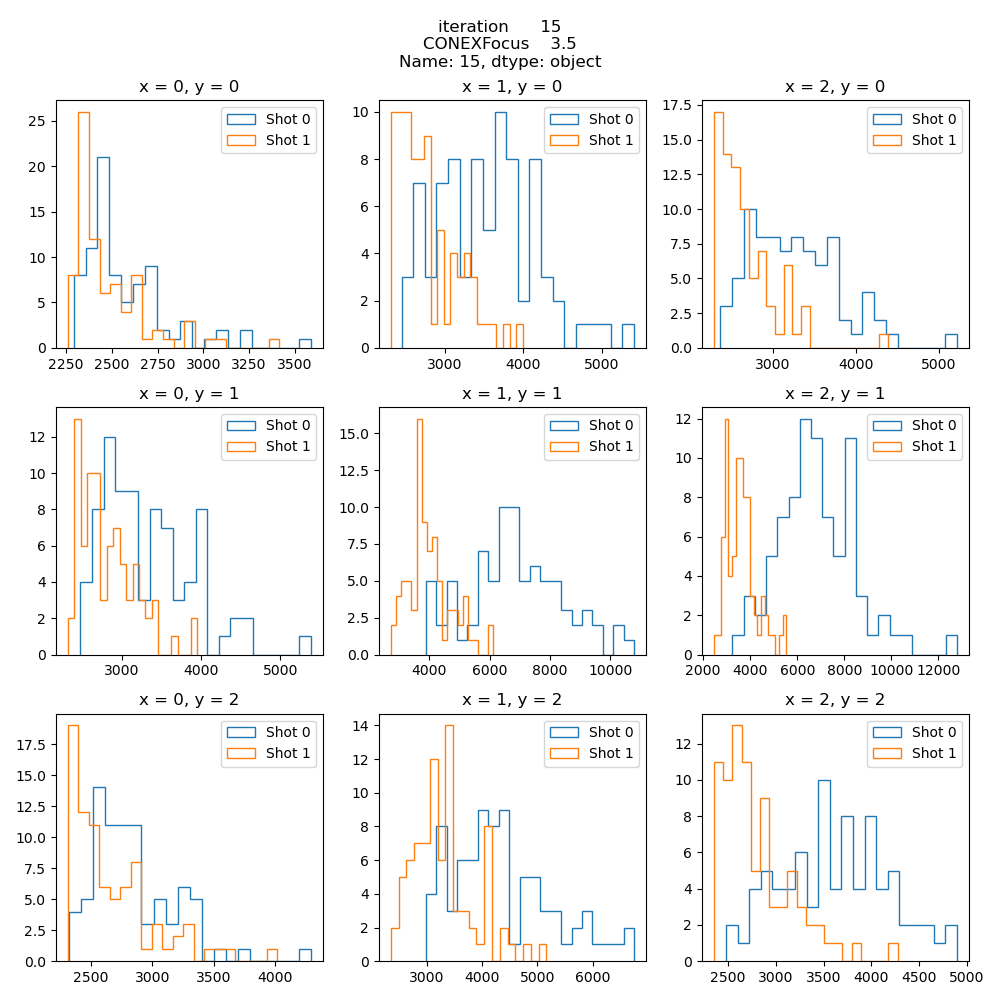

<ipython-input-9-7c4bd0261c63>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axarr = plt.subplots(im_height,im_width,figsize = (10,10))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


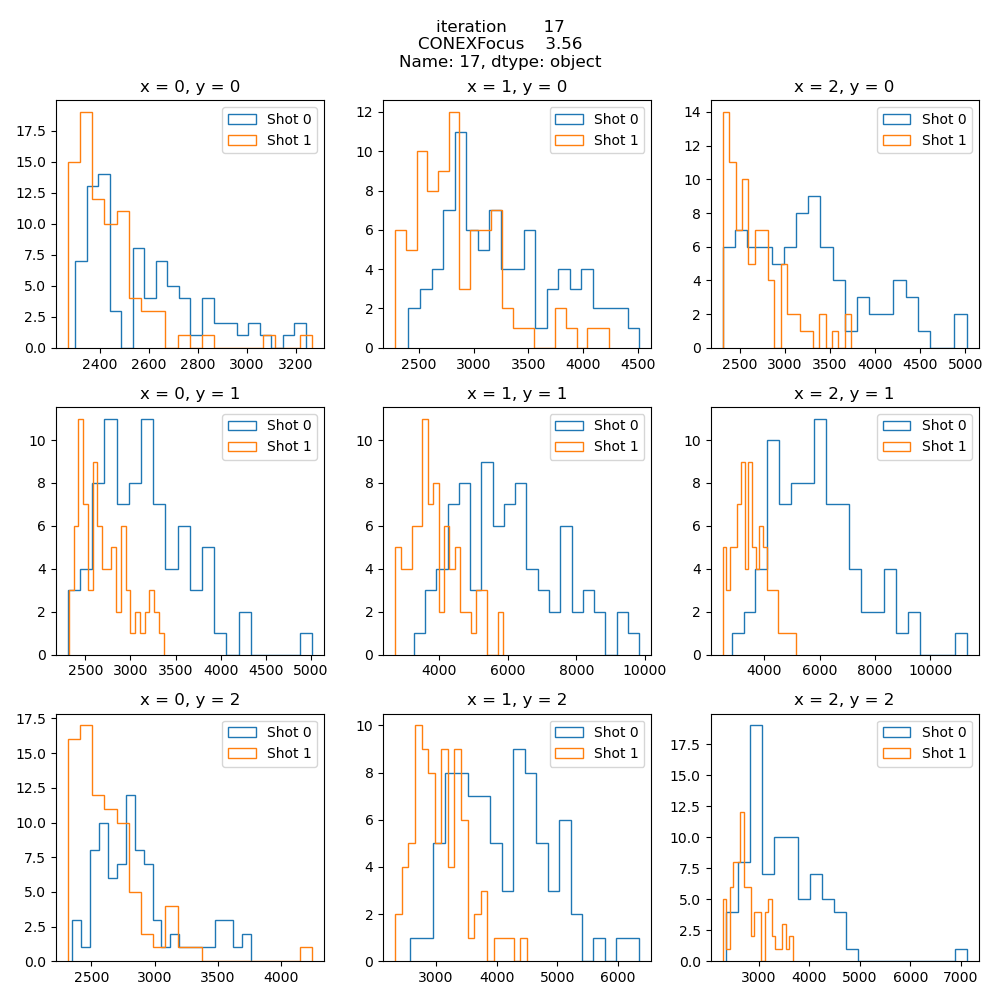

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
im_width = roi.right-roi.left
im_height = roi.bottom-roi.top
for iteration, row in iterations.iterrows():
    i = row['iteration']
    fig,axarr = plt.subplots(im_height,im_width,figsize = (10,10))
    for y in range(im_height):
        for x in range(im_width):
            bns = 20
            for shot in range(shots_per_measurement):
                axarr[y,x].hist(hm_pix[i,:,shot,y,x],bins=bns,histtype='step',label = f"Shot {shot}")
            axarr[y,x].set_title(f"x = {x}, y = {y}")
            axarr[y,x].legend()
    fig.suptitle(str(row))
    fig.tight_layout()
    fig.show()

* Ensure once things get better they can get involved in Madison
* Not isolated
* on slack (check)
* check on classes/TAing

# Loading

In [8]:
cut = 30000
for shot in range(shots_per_measurement):
    f_loaded = (hm_counts[:,:,shot] > cut).sum(1)/measurements
    print(f_loaded)

[0.98675497 0.97350993 1.         0.99337748 0.99337748 0.98013245
 0.99337748 0.99337748 0.98013245 0.98013245 0.99337748 0.98013245
 0.97350993 0.99337748 0.98675497 0.97350993 0.98013245 1.
 0.99337748 0.98675497 0.98013245 0.99337748 0.98013245 0.98675497
 0.97350993 0.99337748 0.98675497 0.9602649  0.99337748 0.97350993
 0.96688742 0.98013245 0.96688742 0.97350993 0.98013245 0.98675497]
[0.00662252 0.00662252 0.01324503 0.00662252 0.00662252 0.01324503
 0.01324503 0.00662252 0.         0.01324503 0.         0.01324503
 0.03311258 0.00662252 0.         0.00662252 0.01324503 0.02649007
 0.00662252 0.         0.02649007 0.02649007 0.01324503 0.00662252
 0.01986755 0.00662252 0.01986755 0.01324503 0.01986755 0.03311258
 0.01986755 0.01986755 0.00662252 0.00662252 0.01986755 0.01324503]


In [6]:
print(measurements)

151


In [23]:
array([149])/150

array([0.99333333])